# Twitter Sentiment Analysis

**Installalling the required packages**

In [194]:
#! pip install --user scipy nltk seaborn textblob

**Importing the required packages**

In [195]:
import numpy as np
import pandas as pd
import json, nltk
import matplotlib.pyplot as plt

import seaborn as sns
nltk.download('wordnet')  

%matplotlib inline

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Federico\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Reading data from CSV file**

N.B. The dataset is not in "UTF-8" encoding

In [196]:
total_data = pd.read_csv("datasets/Twitter_train.csv", encoding="ISO-8859-1")

**Showing the data**

In [197]:
#this opinion is used for setting Pandas DataFrame to show non-truncated table
pd.set_option('display.max_colwidth', -1)

total_data.head()

C:\Users\Federico\AppData\Local\Temp\ipykernel_17992\2783862136.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL friend.............
1,2,0,I missed the New Moon trailer...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...
4,5,0,i think mi bf is cheating on me!!! T_T


**Taking column names into variables**

In [198]:
tweet = total_data.columns.values[2]
sentiment = total_data.columns.values[1]

In [199]:
tweet, sentiment

('SentimentText', 'Sentiment')

## Step 1: Preprocessing

* **Converting every tweets to lower case**
* **Removing punctuations, numbers and special characters**
* **Converting more than 2 letter repetitions to 2 letter ( example (wooooooow --> woow))**
* **Removing extra spaces**
* **Removing Twitter username**
* **Removing URLs**
* **Emoji analysis**
* **Handling the contractions words: " can't " >> " can not ", " won't " >> " will not "**
* **Tokenization (or split with space)**
* **(Optional) Removing stopwords**
* **(Optional) Stemming or Lemmatization**

**Importing Contractions**

In [200]:
with open('assets/contractions.json', 'r') as f:
    contractions_dict = json.load(f)
contractions = contractions_dict['contractions']

In [201]:
contractions

{"ain't": 'am not / are not',
 "aren't": 'are not / am not',
 "can't": 'cannot',
 "can't've": 'cannot have',
 "'cause": 'because',
 "could've": 'could have',
 "couldn't": 'could not',
 "couldn't've": 'could not have',
 "didn't": 'did not',
 "doesn't": 'does not',
 "don't": 'do not',
 "hadn't": 'had not',
 "hadn't've": 'had not have',
 "hasn't": 'has not',
 "haven't": 'have not',
 "he'd": 'he had / he would',
 "he'd've": 'he would have',
 "he'll": 'he shall / he will',
 "he'll've": 'he shall have / he will have',
 "he's": 'he has / he is',
 "how'd": 'how did',
 "how'd'y": 'how do you',
 "how'll": 'how will',
 "how's": 'how has / how is',
 "i'd": 'I had / I would',
 "i'd've": 'I would have',
 "i'll": 'I shall / I will',
 "i'll've": 'I shall have / I will have',
 "i'm": 'I am',
 "i've": 'I have',
 "isn't": 'is not',
 "it'd": 'it had / it would',
 "it'd've": 'it would have',
 "it'll": 'it shall / it will',
 "it'll've": 'it shall have / it will have',
 "it's": 'it has / it is',
 "let's": 'l

**Function for emoji classifications**

In [202]:
def emoji(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :') , :O
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\)|:O)', ' positiveemoji ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' positiveemoji ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' positiveemoji ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-; , @-)
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;|@-\))', ' positiveemoji ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:, :-/ , :-|
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:|:-/|:-\|)', ' negetiveemoji ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' negetiveemoji ', tweet)
    return tweet


**Function for tweet processing**

In [203]:
import re #for using regular expressions

def process_tweet(tweet):
    tweet = tweet.lower()                                             # Lowercases the string
    tweet = re.sub('@[^\s]+', '', tweet)                              # Removes usernames
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', tweet)   # Remove URLs
    tweet = re.sub(r"\d+", " ", str(tweet))                           # Removes all digits
    tweet = re.sub('&quot;'," ", tweet)                               # Remove (&quot;) 
    tweet = emoji(tweet)                                              # Replaces Emojis
    tweet = re.sub(r"\b[a-zA-Z]\b", "", str(tweet))                   # Removes all single characters
    
    #simple tokenization using split()
    for word in tweet.split():
        if word.lower() in contractions:
            tweet = tweet.replace(word, contractions[word.lower()])   # Replaces contractions
    tweet = re.sub(r"[^\w\s]", " ", str(tweet))                       # Removes all punctuations
    tweet = re.sub(r'(.)\1+', r'\1\1', tweet)    # Convert more than 2 letter repetitions to 2 letter (e.g., cooool)
    tweet = re.sub(r"\s+", " ", str(tweet))      # Replaces extra spaces with a single space    
    return tweet


**Processing all the tweets**

We can make a new column in the dataframe for side by side comparison of processed tweets vs original tweets

In [204]:
total_data['processed_tweet'] = np.vectorize(process_tweet)(total_data[tweet])

total_data.head(10)

,ItemID,Sentiment,SentimentText,processed_tweet
0,1,0,is so sad for my APL friend.............,is so sad for my apl friend
1,2,0,I missed the New Moon trailer...,missed the new moon trailer
2,3,1,omg its already 7:30 :O,omg its already
3,4,0,.. Omgaga. Im sooo im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...,omgaga im soo im gunna cry ve been at this dentist since was suposed just get crown put on mins
4,5,0,i think mi bf is cheating on me!!! T_T,think mi bf is cheating on me t_t
5,6,0,or i just worry too much?,or just worry too much
6,7,1,Juuuuuuuuuuuuuuuuussssst Chillin!!,juusst chillin
7,8,0,Sunny Again Work Tomorrow :-| TV Tonight,sunny again work tomorrow negetiveemoji tv tonight
8,9,1,handed in my uniform today . i miss you already,handed in my uniform today miss you already
9,10,1,hmmmm.... i wonder how she my number @-),hmm wonder how she my number


## Other NL text processing (optional):
* **stopword removal**
* **stemming or lemmatization**

**Example of stopword removal**

In [205]:
def stopwords_removal(tweet):
    from nltk.corpus import stopwords
    stopwords = stopwords.words("english")
    
    cleaned_tweet = ""

    for w in tweet.split():
        if w not in stopwords:
            cleaned_tweet = cleaned_tweet +" "+w

    return cleaned_tweet


In [206]:
import nltk
nltk.download("stopwords")

processed_tweet = total_data.columns.values[3]

total_data['clean_tweet'] = np.vectorize(stopwords_removal)(total_data[processed_tweet])

total_data.head(10)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Federico\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,ItemID,Sentiment,SentimentText,processed_tweet,clean_tweet
0,1,0,is so sad for my APL friend.............,is so sad for my apl friend,sad apl friend
1,2,0,I missed the New Moon trailer...,missed the new moon trailer,missed new moon trailer
2,3,1,omg its already 7:30 :O,omg its already,omg already
3,4,0,.. Omgaga. Im sooo im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...,omgaga im soo im gunna cry ve been at this dentist since was suposed just get crown put on mins,omgaga im soo im gunna cry dentist since suposed get crown put mins
4,5,0,i think mi bf is cheating on me!!! T_T,think mi bf is cheating on me t_t,think mi bf cheating t_t
5,6,0,or i just worry too much?,or just worry too much,worry much
6,7,1,Juuuuuuuuuuuuuuuuussssst Chillin!!,juusst chillin,juusst chillin
7,8,0,Sunny Again Work Tomorrow :-| TV Tonight,sunny again work tomorrow negetiveemoji tv tonight,sunny work tomorrow negetiveemoji tv tonight
8,9,1,handed in my uniform today . i miss you already,handed in my uniform today miss you already,handed uniform today miss already
9,10,1,hmmmm.... i wonder how she my number @-),hmm wonder how she my number,hmm wonder number


### Example of stemming

**Snowball Stemmer**

In [207]:
def tweet_stemmer(tweet):
    from nltk.stem import SnowballStemmer

    snowball = SnowballStemmer("english")

    stemmed_tweet = ""
    for w in tweet.split():
        stemmed_tweet = stemmed_tweet +" "+snowball.stem(w)

    return stemmed_tweet

In [208]:
clean_tweet = total_data.columns.values[4]

total_data['snowball_stemmer'] = np.vectorize(tweet_stemmer)(total_data[clean_tweet])

total_data.head(10)

,ItemID,Sentiment,SentimentText,processed_tweet,clean_tweet,snowball_stemmer
0,1,0,is so sad for my APL friend.............,is so sad for my apl friend,sad apl friend,sad apl friend
1,2,0,I missed the New Moon trailer...,missed the new moon trailer,missed new moon trailer,miss new moon trailer
2,3,1,omg its already 7:30 :O,omg its already,omg already,omg alreadi
3,4,0,.. Omgaga. Im sooo im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...,omgaga im soo im gunna cry ve been at this dentist since was suposed just get crown put on mins,omgaga im soo im gunna cry dentist since suposed get crown put mins,omgaga im soo im gunna cri dentist sinc supos get crown put min
4,5,0,i think mi bf is cheating on me!!! T_T,think mi bf is cheating on me t_t,think mi bf cheating t_t,think mi bf cheat t_t
5,6,0,or i just worry too much?,or just worry too much,worry much,worri much
6,7,1,Juuuuuuuuuuuuuuuuussssst Chillin!!,juusst chillin,juusst chillin,juusst chillin
7,8,0,Sunny Again Work Tomorrow :-| TV Tonight,sunny again work tomorrow negetiveemoji tv tonight,sunny work tomorrow negetiveemoji tv tonight,sunni work tomorrow negetiveemoji tv tonight
8,9,1,handed in my uniform today . i miss you already,handed in my uniform today miss you already,handed uniform today miss already,hand uniform today miss alreadi
9,10,1,hmmmm.... i wonder how she my number @-),hmm wonder how she my number,hmm wonder number,hmm wonder number


**Porter Stemmer**

In [209]:
def tweet_porter_stemmer(tweet):
    from nltk.stem import PorterStemmer

    porter = PorterStemmer()

    stemmed_porter_tweet = ""
    for w in tweet.split():
        stemmed_porter_tweet = stemmed_porter_tweet +" "+porter.stem(w)

    return stemmed_porter_tweet

In [210]:
clean_tweet = total_data.columns.values[4]

total_data['porter_stemmer'] = np.vectorize(tweet_porter_stemmer)(total_data[clean_tweet])

total_data.head(10)

,ItemID,Sentiment,SentimentText,processed_tweet,clean_tweet,snowball_stemmer,porter_stemmer
0,1,0,is so sad for my APL friend.............,is so sad for my apl friend,sad apl friend,sad apl friend,sad apl friend
1,2,0,I missed the New Moon trailer...,missed the new moon trailer,missed new moon trailer,miss new moon trailer,miss new moon trailer
2,3,1,omg its already 7:30 :O,omg its already,omg already,omg alreadi,omg alreadi
3,4,0,.. Omgaga. Im sooo im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...,omgaga im soo im gunna cry ve been at this dentist since was suposed just get crown put on mins,omgaga im soo im gunna cry dentist since suposed get crown put mins,omgaga im soo im gunna cri dentist sinc supos get crown put min,omgaga im soo im gunna cri dentist sinc supos get crown put min
4,5,0,i think mi bf is cheating on me!!! T_T,think mi bf is cheating on me t_t,think mi bf cheating t_t,think mi bf cheat t_t,think mi bf cheat t_t
5,6,0,or i just worry too much?,or just worry too much,worry much,worri much,worri much
6,7,1,Juuuuuuuuuuuuuuuuussssst Chillin!!,juusst chillin,juusst chillin,juusst chillin,juusst chillin
7,8,0,Sunny Again Work Tomorrow :-| TV Tonight,sunny again work tomorrow negetiveemoji tv tonight,sunny work tomorrow negetiveemoji tv tonight,sunni work tomorrow negetiveemoji tv tonight,sunni work tomorrow negetiveemoji tv tonight
8,9,1,handed in my uniform today . i miss you already,handed in my uniform today miss you already,handed uniform today miss already,hand uniform today miss alreadi,hand uniform today miss alreadi
9,10,1,hmmmm.... i wonder how she my number @-),hmm wonder how she my number,hmm wonder number,hmm wonder number,hmm wonder number


### Example of Lemmatization

**WordNet Lemmatizer**

In [211]:
def tweet_lemmatizer(tweet):
    from nltk import WordNetLemmatizer

    lemma = WordNetLemmatizer()
    
    lemmatized_tweet = ""
    
    for w in tweet.split():
        lemmatized_tweet = lemmatized_tweet+" "+lemma.lemmatize(w, pos='v')
    return lemmatized_tweet

In [212]:
clean_tweet = total_data.columns.values[4]

total_data['wordnet_lemmatizer'] = np.vectorize(tweet_lemmatizer)(total_data[clean_tweet])

total_data.head(10)

,ItemID,Sentiment,SentimentText,processed_tweet,clean_tweet,snowball_stemmer,porter_stemmer,wordnet_lemmatizer
0,1,0,is so sad for my APL friend.............,is so sad for my apl friend,sad apl friend,sad apl friend,sad apl friend,sad apl friend
1,2,0,I missed the New Moon trailer...,missed the new moon trailer,missed new moon trailer,miss new moon trailer,miss new moon trailer,miss new moon trailer
2,3,1,omg its already 7:30 :O,omg its already,omg already,omg alreadi,omg alreadi,omg already
3,4,0,.. Omgaga. Im sooo im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...,omgaga im soo im gunna cry ve been at this dentist since was suposed just get crown put on mins,omgaga im soo im gunna cry dentist since suposed get crown put mins,omgaga im soo im gunna cri dentist sinc supos get crown put min,omgaga im soo im gunna cri dentist sinc supos get crown put min,omgaga im soo im gunna cry dentist since suposed get crown put mins
4,5,0,i think mi bf is cheating on me!!! T_T,think mi bf is cheating on me t_t,think mi bf cheating t_t,think mi bf cheat t_t,think mi bf cheat t_t,think mi bf cheat t_t
5,6,0,or i just worry too much?,or just worry too much,worry much,worri much,worri much,worry much
6,7,1,Juuuuuuuuuuuuuuuuussssst Chillin!!,juusst chillin,juusst chillin,juusst chillin,juusst chillin,juusst chillin
7,8,0,Sunny Again Work Tomorrow :-| TV Tonight,sunny again work tomorrow negetiveemoji tv tonight,sunny work tomorrow negetiveemoji tv tonight,sunni work tomorrow negetiveemoji tv tonight,sunni work tomorrow negetiveemoji tv tonight,sunny work tomorrow negetiveemoji tv tonight
8,9,1,handed in my uniform today . i miss you already,handed in my uniform today miss you already,handed uniform today miss already,hand uniform today miss alreadi,hand uniform today miss alreadi,hand uniform today miss already
9,10,1,hmmmm.... i wonder how she my number @-),hmm wonder how she my number,hmm wonder number,hmm wonder number,hmm wonder number,hmm wonder number


**Lemmatization with textblob**

In [213]:
def tweet_lemma_with_textblob(tweet):
    from textblob import Word



    lemma_with_textblob_tweet = ""
    for w in tweet.split():
        word_lemma = Word(w)
        lemma_with_textblob_tweet = lemma_with_textblob_tweet +" "+word_lemma.lemmatize()

    return lemma_with_textblob_tweet

In [214]:
clean_tweet = total_data.columns.values[4]

total_data['textblob_lemmatizer'] = np.vectorize(tweet_lemma_with_textblob)(total_data[clean_tweet])

total_data.head(5)

,ItemID,Sentiment,SentimentText,processed_tweet,clean_tweet,snowball_stemmer,porter_stemmer,wordnet_lemmatizer,textblob_lemmatizer
0,1,0,is so sad for my APL friend.............,is so sad for my apl friend,sad apl friend,sad apl friend,sad apl friend,sad apl friend,sad apl friend
1,2,0,I missed the New Moon trailer...,missed the new moon trailer,missed new moon trailer,miss new moon trailer,miss new moon trailer,miss new moon trailer,missed new moon trailer
2,3,1,omg its already 7:30 :O,omg its already,omg already,omg alreadi,omg alreadi,omg already,omg already
3,4,0,.. Omgaga. Im sooo im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...,omgaga im soo im gunna cry ve been at this dentist since was suposed just get crown put on mins,omgaga im soo im gunna cry dentist since suposed get crown put mins,omgaga im soo im gunna cri dentist sinc supos get crown put min,omgaga im soo im gunna cri dentist sinc supos get crown put min,omgaga im soo im gunna cry dentist since suposed get crown put mins,omgaga im soo im gunna cry dentist since suposed get crown put min
4,5,0,i think mi bf is cheating on me!!! T_T,think mi bf is cheating on me t_t,think mi bf cheating t_t,think mi bf cheat t_t,think mi bf cheat t_t,think mi bf cheat t_t,think mi bf cheating t_t


## Step 2: Feature extraction (vectorization)

Machine learning algorithms need to work with numbers. We have to convert the textual data into numbers without losing much of the information. 

One way to do such transformation is *Bag-Of-Words (BOW)* which gives a number to each word.


In [217]:
# uncomment to use other configuration:

# stopwords not removed, no stemming, no lemmatization
tweets = total_data['processed_tweet']

# stopwords removed,  no stemming, no lemmatization
#tweets = total_data['clean_tweet']

# stopwords removed, SnowballStemmer, no lemmatization
#tweets = total_data['clean_stemmed_tweet']

# stopwords removed, PorterStemmer, no lemmatization
#tweets = total_data['clean_stemmed_porter_tweet']

# stopwords removed, no stemming, WordNetLemmatizer
#tweets = total_data['clean_lemmatized_tweet']

# stopwords removed, no stemming, Lemmatizing with textblob
#tweets = total_data['lemma_with_textblob_tweet']

In [218]:
len(tweets)

99989

### Count Vectorizer

**CountVectorizer** it counts the number of words in the document. It converts a collection of text documents to a matrix where the elements are the number of occurences of each word in the document.

**CountVectorizer** gives equal weightage to all the words, i.e., a word weigth is equal to 1 if it is present in that doc else 0. 

In [219]:
#Import required libraries:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(ngram_range=(1,2))    # Unigram (single words) and Bigram (two consecutive words)
final_vectorized_data = count_vectorizer.fit_transform(tweets)  

print(type(final_vectorized_data))

<class 'scipy.sparse.csr.csr_matrix'>


### TF-IDF 

**TF-IDF** (*Term-Frequency-Inverse-Document Frequency*) is different from CountVectorizer as it weights down the common words occuring in almost all the documents of the collection, while it gives more importance to the words that appear in a subset of documents (more discriminative terms). TF-IDF works by considering how frquent is the word in the doc **(TF)** and penalising these common words that appear in most of the documents of the collection **(IDF)**. The assumption is that *rare terms are awarded as they are more informative than frequent terms*

![](assets/tfidf.png)


In [220]:
from sklearn.feature_extraction.text import TfidfVectorizer 

tf_idf_vectorizer = TfidfVectorizer(use_idf = True, ngram_range=(1,3))
final_vectorized_data_TFIDF = tf_idf_vectorizer.fit_transform(tweets)


## Step 3: Sentiment Classification

#### Splitting dataset into train and test sets:
* **train set:** for training the model 
* **test set:** for testing the model's accuracy

**test_size**: 20% of the whole dataset.
**random_state**: Controls the shuffling applied to the data before applying the split.


In [221]:
#uncomment the lines to change vectorizer:

#with CountVectorizer
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_vectorized_data, total_data[sentiment],
                                                     test_size=0.2, random_state=69)  

#with TFIDF
#X_train, X_test, y_train, y_test = train_test_split(final_vectorized_data_TFIDF, total_data[sentiment], 
#                                                    test_size=0.2, random_state=69)  


**Printing splitted dataset sizes**

In [222]:
print("X_train_shape: ",X_train.shape)
print("X_test_shape: ",X_test.shape)
print("y_train_shape: ",y_train.shape)
print("y_test_shape: ",y_test.shape)

X_train_shape:  (79991, 455478)
X_test_shape:  (19998, 455478)
y_train_shape:  (79991,)
y_test_shape:  (19998,)


#### (3.2) Training the model and predicting with Naive Bayes

Popular classifiers based on Naive Bayes are:

* Bernoulli Naive Bayes
* Gaussian Naive Bayes classifier
* Multinomial Naive Bayes

We are going to use **Multinomial Naive Bayes, Bernoulli Naive Bayes and Complement Naive Bayes**. 

**Bayes theorem:**
![](assets/bayes_formula.jpg)

**Multinomial Naive Bayes classifier**

In [223]:
from sklearn.naive_bayes import MultinomialNB  # Naive Bayes Classifier

model_naive = MultinomialNB().fit(X_train, y_train) 
predicted_naive = model_naive.predict(X_test)

**Bernoulli Naive Bayes classifier**

In [224]:
from sklearn.naive_bayes import BernoulliNB  # Naive Bayes Classifier

model_naive_Ber = BernoulliNB().fit(X_train, y_train) 
predicted_naive_Ber = model_naive_Ber.predict(X_test)

**Complement Naive Bayes classifier**

In [225]:
from sklearn.naive_bayes import ComplementNB  # Naive Bayes Classifier

model_naive_Comp = ComplementNB().fit(X_train, y_train) 
predicted_naive_Comp = model_naive_Comp.predict(X_test)

## Analyzing the results

**Print Confusion matrix**

The confusion_matrix function evaluates classification accuracy by computing the confusion matrix with each row corresponding to the true class.

**MultinomialNB confusion matrix**

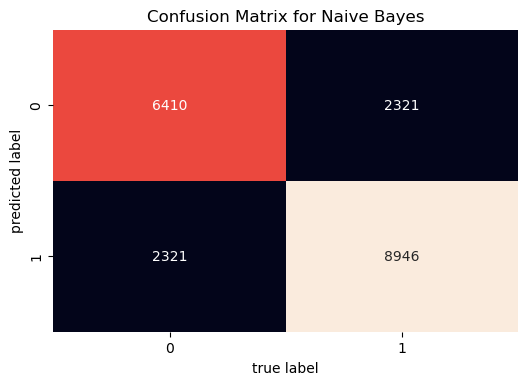

In [226]:
from sklearn.metrics import confusion_matrix

plt.figure(dpi=100)
mat = confusion_matrix(y_test, predicted_naive)
sns.heatmap(mat.T, annot=True, fmt='d', cbar=False)

plt.title('Confusion Matrix for Naive Bayes')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.savefig("assets/confusion_matrix.png")
plt.show()

**BernoulliNB confusion matrix**

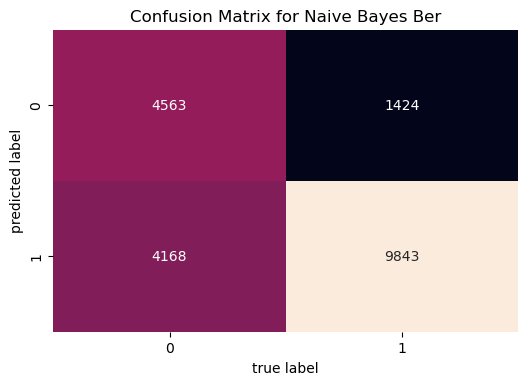

In [227]:
plt.figure(dpi=100)
mat = confusion_matrix(y_test, predicted_naive_Ber)
sns.heatmap(mat.T, annot=True, fmt='d', cbar=False)

plt.title('Confusion Matrix for Naive Bayes Ber')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.savefig("assets/confusion_matrix_Ber.png")
plt.show()

**ComplementNB confusion matrix**

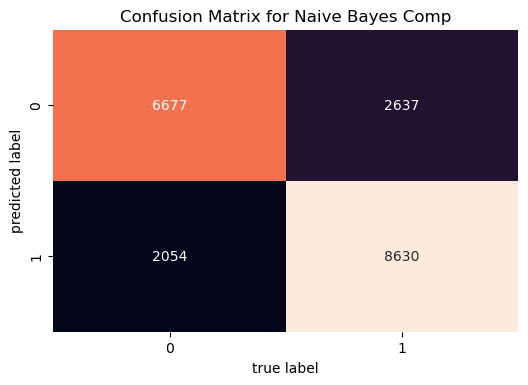

In [228]:
plt.figure(dpi=100)
mat = confusion_matrix(y_test, predicted_naive_Comp)
sns.heatmap(mat.T, annot=True, fmt='d', cbar=False)

plt.title('Confusion Matrix for Naive Bayes Comp')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.savefig("assets/confusion_matrix_Comp.png")
plt.show()

**Computing the accuracy of our prediction**

Accuracy = (TP + TN)/(TP + FP + TN + FN)
- TP: true positive
- TN: true negative
- FP: false positive 
- FN: false negative

In [229]:
from sklearn.metrics import accuracy_score

score_naive = accuracy_score(predicted_naive, y_test)
print("Accuracy with Multinomial Naive-bayes:", score_naive)

Accuracy with Multinomial Naive-bayes: 0.7678767876787679


In [230]:
#from sklearn.metrics import accuracy_score

score_naive_Ber = accuracy_score(predicted_naive_Ber, y_test)
print("Accuracy with Bernoulli Naive-bayes:", score_naive_Ber)

Accuracy with Bernoulli Naive-bayes: 0.7203720372037203


In [231]:
#from sklearn.metrics import accuracy_score

score_naive_Comp = accuracy_score(predicted_naive_Comp, y_test)
print("Accuracy with Complement Naive-bayes:", score_naive_Comp)

Accuracy with Complement Naive-bayes: 0.7654265426542655


**Precision, recall, and accuracy**

These are the standard metrics used to evaluate the performance of a classifier.

* **Precision:** measures how many docs are predicted correctly as belonging to a given category out of all of the docs that are predicted (correctly and incorrectly) as belonging to the category. P = TP / (TP + FP)

* **Recall:** measures how many texts were predicted correctly as belonging to a given category out of all the texts that should have been predicted as belonging to the category. We also know that the more data we feed our classifiers with, the better recall will be. R = TP / (TP + FN)

* **Accuracy:** measures how many texts were predicted correctly (both as belonging to a category and not belonging to the category) out of all of the texts in the corpus. A = TP + TN / (TP + FP + TN + FN)

**N.B. precision and recall are used to measure performance since accuracy alone does not say much about how good or bad a classifier is**

**Multinomial Naive Bayes classifier**

In [232]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted_naive))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73      8731
           1       0.79      0.79      0.79     11267

    accuracy                           0.77     19998
   macro avg       0.76      0.76      0.76     19998
weighted avg       0.77      0.77      0.77     19998



**Bernoulli Naive Bayes classifier**

In [233]:
print(classification_report(y_test, predicted_naive_Ber))

              precision    recall  f1-score   support

           0       0.76      0.52      0.62      8731
           1       0.70      0.87      0.78     11267

    accuracy                           0.72     19998
   macro avg       0.73      0.70      0.70     19998
weighted avg       0.73      0.72      0.71     19998



**Complement Naive Bayes classifier**

In [234]:
print(classification_report(y_test, predicted_naive_Comp))

              precision    recall  f1-score   support

           0       0.72      0.76      0.74      8731
           1       0.81      0.77      0.79     11267

    accuracy                           0.77     19998
   macro avg       0.76      0.77      0.76     19998
weighted avg       0.77      0.77      0.77     19998



## Visualizing results

**Drawing ROC curve**

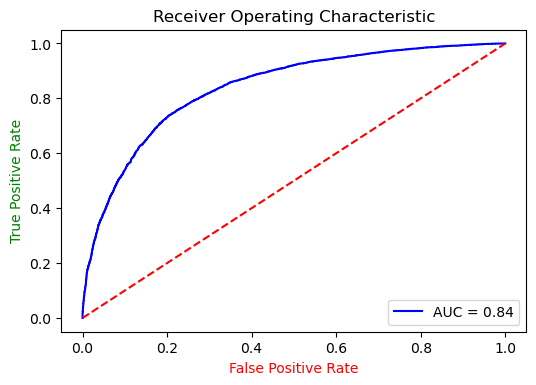

In [235]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# calculate the fpr and tpr for all thresholds of the classification
probs = model_naive.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
plt.figure(dpi=100)                       # to plot high quality graph
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate', color='g')
plt.xlabel('False Positive Rate', color='r')
plt.savefig("assets/ROC_curve.png")
plt.show()

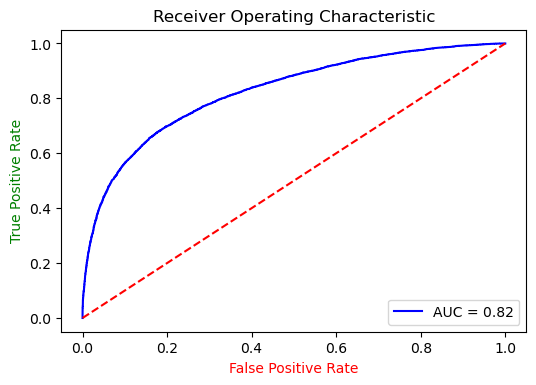

In [236]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# calculate the fpr and tpr for all thresholds of the classification
probs = model_naive_Ber.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
plt.figure(dpi=100)                       # to plot high quality graph
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate', color='g')
plt.xlabel('False Positive Rate', color='r')
plt.savefig("assets/ROC_curve_Ber.png")
plt.show()

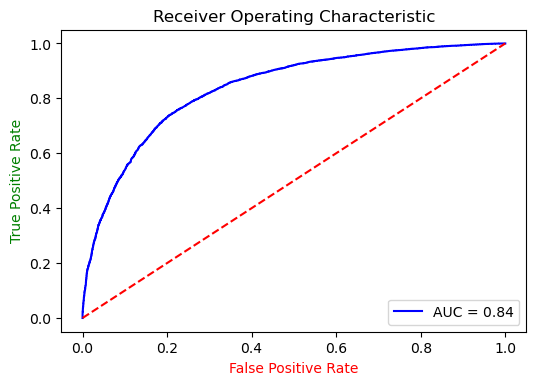

In [237]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# calculate the fpr and tpr for all thresholds of the classification
probs = model_naive_Comp.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
plt.figure(dpi=100)                       # to plot high quality graph
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate', color='g')
plt.xlabel('False Positive Rate', color='r')
plt.savefig("assets/ROC_curve_Comp.png")
plt.show()

## Conclusions

In our analysis we compared the results achieved with different 
- classifiers: Multinomial Naive-Bayes, Bernoulli Naive-Bayes and Complement Naive-Bayes
- approaches for vectorization: CountVectorizer vs. TF-IDF
- approaches for tweet processing: 
  - *text normalization*: None, SnowballStemmer, PorterStemmer, WordNetLemmatizer, TextBlobLemmatizer
  - with or without *stopword removal*

In *Table 1*, we showed the accuracy rate for different combinations (vectorizer, stopwords, normalization). The results are highlighted by value (dark blue higher values).

**Table 1**

In [238]:

results = {'Normalization': ["None", "None", "WordNetLemmatizer", "WordNetLemmatizer", "SnowballStemmer", "SnowballStemmer", "PorterStemming", "PorterStemming", "TextBlobLemmatizer", "TextBlobLemmatizer"],
        'Stop Words': ["No", "No", "Yes", "Yes","Yes", "Yes","Yes", "Yes", "Yes", "Yes"],
        'Vectorizer': ["Count", "Tf-Idf", "Count", "Tf-Idf", "Count", "Tf-Idf", "Count", "Tf-Idf", "Count", "Tf-Idf"],
           
        'Accuracy MultinomialNB': [0.7678767876787679, 0.7355235523552355,  0.7396239623962396
                                   , 0.7152715271527152, 0.7391239123912391, 0.7171217121712171, 
                                   0.7382738273827383, 0.7167216721672167, 0.7415241524152415, 0.7170717071707171],
           
        'Accuracy BernoulliNB': [0.7203720372037203 , 0.6765176517651765, 0.6911691169116911, 
                                 0.64996499649965, 0.6937693769376938, 0.6510651065106511, 
                                 0.6936193619361937, 0.6504650465046504, 0.6908690869086909, 0.6488148814881488],
           
        'Accuracy ComplementNB': [0.7654265426542655, 0.7707270727072707, 0.7364736473647365, 
                                  0.7445744574457446, 0.7373237323732373, 0.7437243724372438, 
                                  0.7368736873687368, 0.7435743574357436, 0.7371237123712371, 0.7464246424642464 ]
          }

df = pd.DataFrame(results)

def make_pretty(styler):
    styler.background_gradient(axis=None, vmin=0.65, vmax=0.8, cmap="YlGnBu")
    return styler

df.style.pipe(make_pretty)


,Normalization,Stop Words,Vectorizer,Accuracy MultinomialNB,Accuracy BernoulliNB,Accuracy ComplementNB
0,None,No,Count,0.767877,0.720372,0.765427
1,None,No,Tf-Idf,0.735524,0.676518,0.770727
2,WordNetLemmatizer,Yes,Count,0.739624,0.691169,0.736474
3,WordNetLemmatizer,Yes,Tf-Idf,0.715272,0.649965,0.744574
4,SnowballStemmer,Yes,Count,0.739124,0.693769,0.737324
5,SnowballStemmer,Yes,Tf-Idf,0.717122,0.651065,0.743724
6,PorterStemming,Yes,Count,0.738274,0.693619,0.736874
7,PorterStemming,Yes,Tf-Idf,0.716722,0.650465,0.743574
8,TextBlobLemmatizer,Yes,Count,0.741524,0.690869,0.737124
9,TextBlobLemmatizer,Yes,Tf-Idf,0.717072,0.648815,0.746425


**Bar-chart**

In the bar-chart we showed the same results in Table 1 in order to highlight the different results obtained with CountVectorizer and TFIDF for each classifier

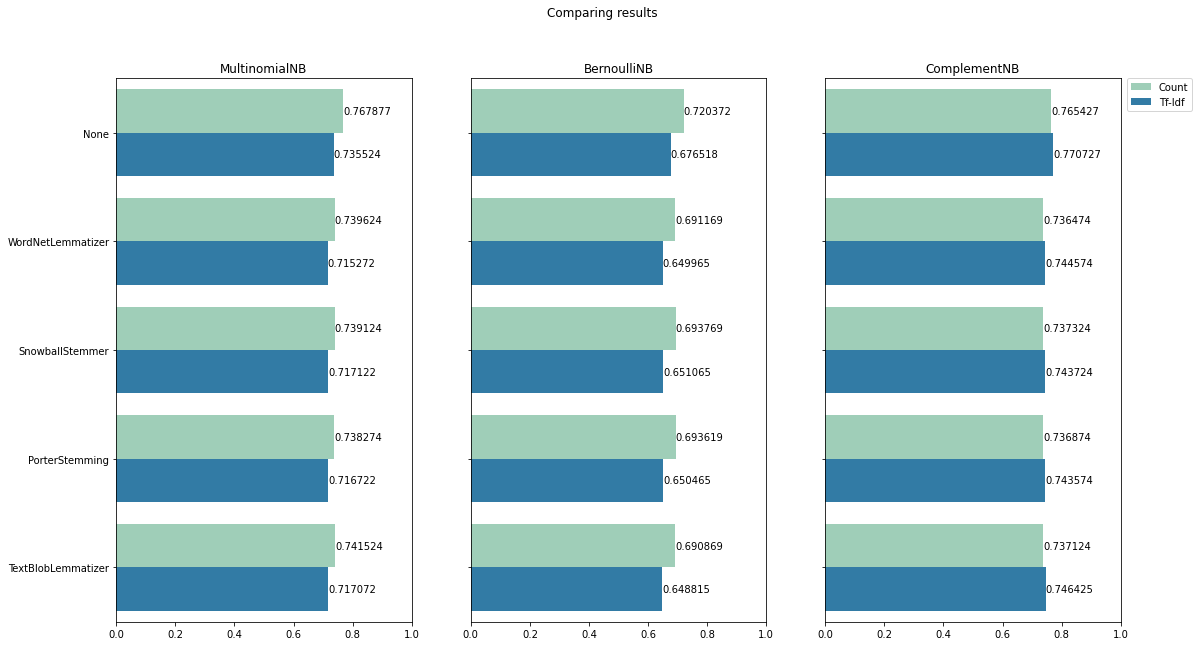

In [239]:
fig, axes = plt.subplots(1, 3, figsize=(18, 10), sharey=True)
fig.suptitle('Comparing results')


a = sns.barplot(ax=axes[0], y="Normalization", x="Accuracy MultinomialNB", hue="Vectorizer", data=results, orient="h", palette="YlGnBu")
a.legend_.remove()
a.set(xlim=(0,1))
axes[0].set_title("MultinomialNB")
for container in a.containers:
    a.bar_label(container)

b = sns.barplot(ax=axes[1], y="Normalization", x="Accuracy BernoulliNB", hue="Vectorizer", data=results, orient="h", palette="YlGnBu")
b.legend_.remove()
b.set(xlim=(0,1))
axes[1].set_title("BernoulliNB")
for container in b.containers:
    b.bar_label(container)

c = sns.barplot(ax=axes[2], y="Normalization", x="Accuracy ComplementNB", hue="Vectorizer", data=results, orient="h", palette="YlGnBu")
c.legend_.remove()
c.set(xlim=(0,1))
axes[2].set_title("ComplementNB")
for container in c.containers:
    c.bar_label(container)
    
c.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig("assets/Compare_results.png")
    

#### Results

It seems that the best combination for sentiment analysis with the Twitter dataset is using

* **Without normalization (no Stemming or Lemmatizing)**
* **Without stopwords removal**
* **Tf-Idf Vectorizer**

**Leaderboard Highest : 0.79249**
**Multinomial Naive model : 0.76788**
**Complement Naive model : 0.770727**
 
As shown in Table 1, Multinomial and Complement approaches seem to produce better accuracy score than the Bernoulli's one.

We also observed that the Complement algorithm seems to be less affected by the vectorizer model.

For both types of Vectorizer we noticed an higher accuracy score when no stepword or normalization are used. 

Usually, for document analysis the best combination will include lemmatization, stopwords removal, etc. In sentiment analysis, we can see that they aren't providing edge over the raw data. 



## Other Analysis on positive/negative tweets

**Showing statistics**

In [245]:
total_data[sentiment]

0        0
1        0
2        1
3        0
4        0
        ..
99984    0
99985    1
99986    0
99987    1
99988    1
Name: Sentiment, Length: 99989, dtype: int64

**Test-set sentiment distribution**

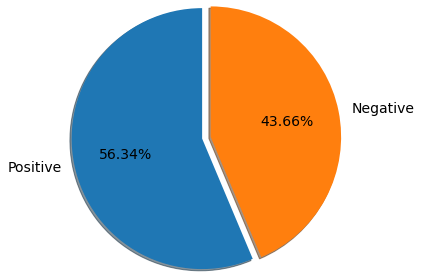

19998


In [295]:
sentiments = ['Positive', 'Negative'] 
plt.rcParams['font.size'] = 14.0
#1 for positive and 0 for negative sentiment
slices = [(y_test != 0).sum(), (y_test == 0).sum()] 
#colors = ['y', 'c'] 
plt.pie(slices, labels = sentiments, startangle=90, shadow = True,
        explode = (0, 0.1), radius = 1.5, autopct = '%1.2f%%') 
#plt.legend()
plt.savefig("pie_ytest.png")
plt.show() 
print(len(y_test))

**MultinomiaNB predicted sentiment distribution**

Comparing this result with the graph above, obtained using the test-set data, we observed the same distribution of the sentiment behavior; this aspect is confirmed by the confusion matrix showed before which return an equal count of FP and FN. 

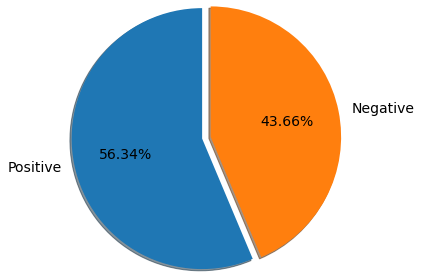

19998


In [287]:
sentiments = ['Positive', 'Negative'] 
#1 for positive and 0 for negative sentiment
slices = [(predicted_naive != 0).sum(), (predicted_naive == 0).sum()] 
#colors = ['g', 'r'] 
plt.pie(slices, labels = sentiments, startangle=90, shadow = True,
        explode = (0, 0.1), radius = 1.5, autopct = '%1.2f%%') 
#plt.legend()
plt.savefig("pie_Multinomial.png")
plt.show() 
print(len(predicted_naive))

**BernoulliNB predicted sentiment distribution**

The Bernoulli approach seems to overestimate the number of positive sentiment. 

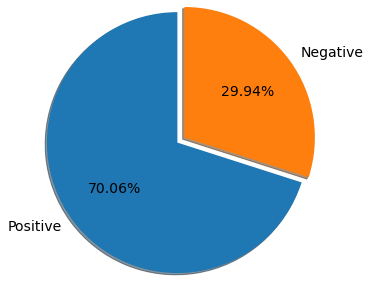

19998


In [288]:
sentiments = ['Positive', 'Negative'] 
#1 for positive and 0 for negative sentiment
slices = [(predicted_naive_Ber != 0).sum(), (predicted_naive_Ber == 0).sum()] 
#colors = ['g', 'r'] 
plt.pie(slices, labels = sentiments, startangle=90, shadow = True,
        explode = (0, 0.1), radius = 1.5, autopct = '%1.2f%%') 
plt.savefig("pie_Bernoulli.png")
plt.show() 
print(len(predicted_naive_Ber))

**ComplementNB predicted sentiment distribution**

In this last case, the result is close to the Multinomial's one.

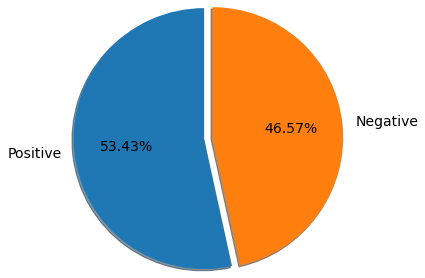

19998


In [289]:
sentiments = ['Positive', 'Negative'] 
#1 for positive and 0 for negative sentiment
slices = [(predicted_naive_Comp != 0).sum(), (predicted_naive_Comp == 0).sum()] 
#colors = ['g', 'r'] 
plt.pie(slices, labels = sentiments, startangle=90, shadow = True,
        explode = (0, 0.1), radius = 1.5, autopct = '%1.2f%%') 
#plt.legend()
plt.savefig("pie_Complement.png")
plt.show() 
print(len(predicted_naive_Comp))